# **Recommendation Systems**

In this ipython notebook we'll be making a few recommendation systems that recommend movies.

First thigs first, let's read the csv files. We'll be using the MovieLens dataset.

In [1]:
datapath = 'sample_data/'

In [2]:
import pandas as pd
import numpy as np

movies_df = pd.read_csv(datapath + 'movies.csv')
ratings_df = pd.read_csv(datapath + 'ratings.csv')
tags_df = pd.read_csv(datapath + 'tags.csv')

Let's take a peek of the dataframes

In [3]:
movies_df

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [4]:
ratings_df

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [5]:
tags_df

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200
...,...,...,...,...
3678,606,7382,for katie,1171234019
3679,606,7936,austere,1173392334
3680,610,3265,gun fu,1493843984
3681,610,3265,heroic bloodshed,1493843978


In [6]:
ratings_sorted = ratings_df.sort_values(by=['movieId'])
ratings_sorted.head(10)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
81531,517,1,4.0,1487954343
30517,213,1,3.5,1316196157
81082,514,1,4.0,1533872400
30601,214,1,3.0,853937855
30721,216,1,3.0,975211713
30885,217,1,4.0,955942540
31524,219,1,3.5,1194681084
80373,509,1,4.0,1435992343
32052,220,1,5.0,1230055565


For each movieId we're going to find the average rating

In [7]:
avg_rating = (ratings_sorted.groupby(['movieId'], as_index=False).mean().groupby('movieId')['rating'].mean())
avg_rating = avg_rating.to_frame()
avg_rating

,rating
movieId,
1,3.920930
2,3.431818
3,3.259615
4,2.357143
5,3.071429
...,...
193581,4.000000
193583,3.500000
193585,3.500000


In [8]:
count_rating = ratings_sorted.groupby(['movieId'])['movieId'].count()
count_rating = count_rating.to_frame()
count_rating.rename(columns = {'movieId':'no_of_votes'}, inplace = True)
count_rating

,no_of_votes
movieId,
1,215
2,110
3,52
4,7
5,49
...,...
193581,1
193583,1
193585,1


In [9]:
ratings = avg_rating.merge(count_rating, on = 'movieId')
ratings

,rating,no_of_votes
movieId,,
1,3.920930,215
2,3.431818,110
3,3.259615,52
4,2.357143,7
5,3.071429,49
...,...,...
193581,4.000000,1
193583,3.500000,1
193585,3.500000,1


# **Demographic Filtering**

We need to filter out movies that have very few votes

In [10]:
mean_vote = ratings['rating'].mean()
mean_vote

3.2624482748109656

So the average rating is about 3.26 out of 5

Now, we'll calculate the average vote count.

In [11]:
mean_vote_count = ratings['no_of_votes'].mean()
mean_vote_count

10.369806663924312

We need to filter out movies that have very few votes. If a movie is rated 5.0 but only by 1 user, we cannot recommend that movie.
A good metric is the 90th percentile as our cut off. That means that a movie can be recommended only if it has more votes than 90% percent of the movies in the list.

In [12]:
cutoff_votes = ratings['no_of_votes'].quantile(0.9)
cutoff_votes

27.0

So now, we'll remove all the movies that have less than 27 votes.

In [13]:
eligible_movies = ratings.copy().loc[ratings['no_of_votes'] >= cutoff_votes]
eligible_movies.shape

(976, 2)

In [14]:
ratings.shape

(9724, 2)

Out of all the 9,724 movies we only keep 976 movies.

Now we need a metric to show if we should recommend a movie. We'll use IMDb's formula, weighted rating (wr) :

wr = (v / (v + m)) * R + (m / (v + m)) * C

Where, v is no_of_votes, m is cutoff_votes, R is the rating of the movie and C is mean_vote.

Now, we'll define a funtion that has a dataframe as input and returns a column with the weighted rating score.




In [15]:
def weighted_rating(movies, m=cutoff_votes, C=mean_vote):
    v = movies['no_of_votes']
    R = movies['rating']
    return (v/(v+m) * R) + (m/(m+v) * C)

Now we apply the function on the dataframe and create a new column that has the weighted rating (score) for each movie.

In [16]:
eligible_movies['score'] = eligible_movies.apply(weighted_rating, axis=1)
eligible_movies

,rating,no_of_votes,score
movieId,,,
1,3.920930,215,3.847463
2,3.431818,110,3.398439
3,3.259615,52,3.260584
5,3.071429,49,3.139291
6,3.946078,102,3.802993
...,...,...,...
134130,4.000000,48,3.734481
134853,3.813953,43,3.601230
139385,3.903226,31,3.604933


Now we sort the dataframe based on score and print the 10 highest rated movies.

In [17]:
eligible_movies = eligible_movies.sort_values('score', ascending=False)
top_recommended_movies = eligible_movies.merge(movies_df[['movieId','title']], on='movieId')
top_recommended_movies.head(10)

,movieId,rating,no_of_votes,score,title
0,318,4.429022,317,4.337460,"Shawshank Redemption, The (1994)"
1,858,4.289062,192,4.162494,"Godfather, The (1972)"
2,2959,4.272936,218,4.161576,Fight Club (1999)
3,260,4.231076,251,4.137000,Star Wars: Episode IV - A New Hope (1977)
4,50,4.237745,204,4.123749,"Usual Suspects, The (1995)"
5,296,4.197068,307,4.121515,Pulp Fiction (1994)
6,527,4.225000,220,4.119782,Schindler's List (1993)
7,2571,4.192446,278,4.110118,"Matrix, The (1999)"
8,1196,4.215640,211,4.107505,Star Wars: Episode V - The Empire Strikes Back...
9,356,4.164134,329,4.095747,Forrest Gump (1994)


Text(0.5, 1.0, 'Highest Rated Movies')

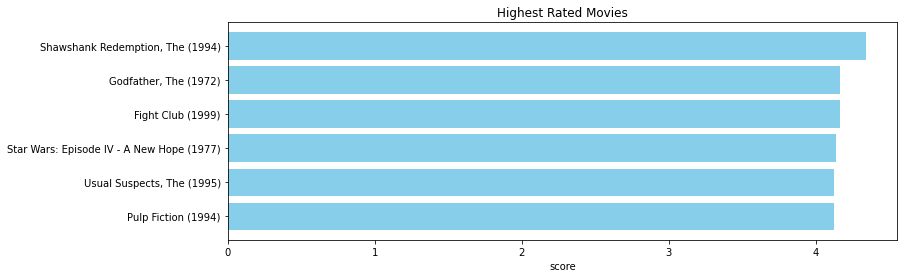

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

plt.barh(top_recommended_movies['title'].head(6),top_recommended_movies['score'].head(6), align='center', color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel("score")
plt.title("Highest Rated Movies")

This recommendation system recommends a general chart of movies to all users. The recommendation isn't personalized, the personal taste and interests of a particular user isn't being considerated. That's what we are going to consider in the next section.

# **Tag Based Filtering**

We will compute similarity scores for all movies based on their description from users. We'll be doing that by performing text processing.

There are too many tags and the dataframes that will be created will be too big to process, so we'll use 1/6 of the given tags.

In [19]:
tags_df['tag'] = tags_df['tag'].fillna('')
print(tags_df.shape)

(3683, 4)


We need to gather every tag for each movie.

In [20]:
tags = tags_df.groupby(['movieId'])['tag'].apply(', '.join).reset_index()
tags

,movieId,tag
0,1,"pixar, pixar, fun"
1,2,"fantasy, magic board game, Robin Williams, game"
2,3,"moldy, old"
3,5,"pregnancy, remake"
4,7,remake
...,...,...
1567,183611,"Comedy, funny, Rachel McAdams"
1568,184471,"adventure, Alicia Vikander, video game adaptation"
1569,187593,"Josh Brolin, Ryan Reynolds, sarcasm"
1570,187595,"Emilia Clarke, star wars"


We need to convert the word vector for each movie and compute the Term Frequency-Inverse Document Frequency (TF-IDF) vectors.

Term Frequency is the relative frequency of a word in a document and it's given as term_instances/total_instances.

Inverse Document Frequency is the relative count of documents containing the term is given as log(number_of_documents/documents_with_term) The overall importance of each word to the documents in which they appear is equal to TF * IDF.

This will give us a matrix where each column represents a word in the overview vocabulary (all the words that appear in at least one document) and each column represents a movie, as before.This is done to reduce the importance of words that occur frequently in plot overviews and therefore, their significance in computing the final similarity score.

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

# tf-idf vectorizer object. removing all the stop words
tfidf = TfidfVectorizer(stop_words='english')

tfidf_matrix = tfidf.fit_transform(tags['tag'])
tfidf_matrix.shape

(1572, 1673)

This means that over 17,000 words are used to describe over 30,000 movies. Now with this matrix we can compute a similarity score. We'll use the cosine similarity function ( linear_kernel() ).

In [22]:
from sklearn.metrics.pairwise import linear_kernel

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [23]:
cosine_sim

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [24]:
indices = pd.Series(movies_df.index, index=movies_df['title']).drop_duplicates()
indices

title
Toy Story (1995)                                0
Jumanji (1995)                                  1
Grumpier Old Men (1995)                         2
Waiting to Exhale (1995)                        3
Father of the Bride Part II (1995)              4
                                             ... 
Black Butler: Book of the Atlantic (2017)    9737
No Game No Life: Zero (2017)                 9738
Flint (2017)                                 9739
Bungo Stray Dogs: Dead Apple (2018)          9740
Andrew Dice Clay: Dice Rules (1991)          9741
Length: 9742, dtype: int64

Now, we're going to define a function that takes in a movie title as input and outputs a list of the 10 most similiar movies, based on the users' tags.

In [25]:
def get_recommendations(title, cosine_sim=cosine_sim):
    # get the index of the movie
    idx = indices[title]
    
    # get the pairwise similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # sort the list based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse = True)
    
    # get the score of the top 10 most similar movies
    sim_scores = sim_scores[1:11]
    
    # get the movie indices
    movie_indices = [i[0] for i in sim_scores]
    
    # return the top 10 most similar movie titles
    return movies_df['title'].iloc[movie_indices]

Let's check it out!

In [26]:
iii = indices['Toy Story (1995)'] 
#print(np.where(tags.movieId == iii))
tags.loc(0)

In [27]:
get_recommendations('Toy Story (1995)')

544                     Nelly & Monsieur Arnaud (1995)
666     Supercop 2 (Project S) (Chao ji ji hua) (1993)
1524                 In Search of the Castaways (1962)
1427                   In the Heat of the Night (1967)
1510                  Cat from Outer Space, The (1978)
1497             Last Temptation of Christ, The (1988)
1457    Friday the 13th Part VII: The New Blood (1988)
77                                 White Squall (1996)
1                                       Jumanji (1995)
2                              Grumpier Old Men (1995)
Name: title, dtype: object

In [28]:
get_recommendations('Before Sunrise (1995)')

183                                 Before Sunrise (1995)
884                                  Grifters, The (1990)
912      Wings of Desire (Himmel über Berlin, Der) (1987)
1024                                   Blood Beach (1981)
847               Single Girl, A (Fille seule, La) (1995)
732                    Around the World in 80 Days (1956)
771                               Parent Trap, The (1961)
1186                                Simple Wish, A (1997)
1264                         Chairman of the Board (1998)
204     Far From Home: The Adventures of Yellow Dog (1...
Name: title, dtype: object

# **Recommendations based on genre**

We'll give movie recommendations to the users based on the genre of the movies. What we'll do is similar to the tag based recommendations but instead of using TF-IDF we'll be using the CountVectorizer().


In [29]:
# import CountVectorizer and create the count matrix
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(movies_df['genres'])

In [30]:
# compute the Cosine Similarity matrix based on the count_matrix
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

We need an index matrix, but we've already made that above.

We can now reuse our get_recommendations() function by passing in the new cosine_sim2 matrix as your second argument.

In [31]:
get_recommendations('Jumanji (1995)', cosine_sim2)

53                     Indian in the Cupboard, The (1995)
109                     NeverEnding Story III, The (1994)
767                       Escape to Witch Mountain (1975)
1514            Darby O'Gill and the Little People (1959)
1556                                  Return to Oz (1985)
1617                        NeverEnding Story, The (1984)
1618    NeverEnding Story II: The Next Chapter, The (1...
1799                        Santa Claus: The Movie (1985)
3574    Harry Potter and the Sorcerer's Stone (a.k.a. ...
6075    Chronicles of Narnia: The Lion, the Witch and ...
Name: title, dtype: object

In [32]:
get_recommendations('Anne Frank Remembered (1995)', cosine_sim2)

87                  Heidi Fleiss: Hollywood Madam (1995)
96                                        Catwalk (1996)
101                         Anne Frank Remembered (1995)
110                                Jupiter's Wife (1994)
114                               Man of the Year (1995)
135                                         Crumb (1994)
174                                      Unzipped (1995)
210                                   Hoop Dreams (1994)
321    Wonderful, Horrible Life of Leni Riefenstahl, ...
487                                 War Room, The (1993)
Name: title, dtype: object

# **Singular Value Decomposition (SVD)**

Demographic Filtering was very limiting, because it was only capable of suggesting movies which are close to a certain movie. It wasn't capable of capturing personal tastes and biases of a user to provide recommendations. This is what Collaborative Filtering does. Collaborative Filtering is a technique that suggests items that a user might like based on the reactions by similar users. It works by searching a large group of people and finding a smaller set of users with tastes similar to a particular user.

Singular Vector Decomposition (SVD) is a powerful dimensionality reduction technique that is used heavily in modern model-based Collaborative Filtering recommendetion System. SVD factorizes a matrix M (m x n), where m are the all users and n are all the movies. Each cell (i,j) of the matrix has the rating user i has given the movie j and if a user hasn't seen a movie, the rating we put is 0.0. SVD factorizes M in a way that M = U * sigma * Vt . U is a m x m matrix that represents the users' features, sigma is a m x n diagonal matrix that represents the weights of each concept, Vt is n x n matrix that represents the movies' features.

The idea is that when factorizing the matrix, in order the new matrices to fit as good as possible the original matrix, the empty cell (movies not rated) are getting filled with an approximation of what we think the user would rate a movie.

First things first, we need to create the matrix M.

In [33]:
ratings_df

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [34]:
movies_df

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [35]:
no_users = ratings_df.userId.unique().shape[0]
no_movies = movies_df.movieId.unique().shape[0]
print('Number of users = ' + str(no_users) + ' | Number of movies = ' + str(no_movies))

Number of users = 610 | Number of movies = 9742


In [36]:
ratings = ratings_df.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(0)
ratings

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,2.5,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We need to de-normalize the data (normalize by each users mean) and convert it from a dataframe to a numpy array.

In [37]:
M = ratings.to_numpy()
user_ratings_mean = np.mean(M, axis = 1)
Ratings_demeaned = M - user_ratings_mean.reshape(-1, 1)

Now, we are ready to do some dimensionality reduction!

In [38]:
from scipy.sparse.linalg import svds

U, sigma, Vt = svds(Ratings_demeaned, k = 50)

k = 50 is the number of latent features we want. The bigger k is, the better the prediction is. We are going to convert the sigma matrix to the diagonal matrix form.

In [39]:
sigma = np.diag(sigma)

All we have to do now is multiply the matrices to get the approxiamation of the rating. (We need to add the user means back to get the actual star ratings prediction)

In [40]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)

predictions = pd.DataFrame(all_user_predicted_ratings, index = ratings.index, columns = ratings.columns)
predictions

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,2.167328,0.402751,0.840184,-0.076281,-0.551337,2.504091,-0.890114,-0.026443,0.196974,1.593259,...,-0.023453,-0.019967,-0.026939,-0.026939,-0.023453,-0.026939,-0.023453,-0.023453,-0.023453,-0.058732
2,0.211459,0.006658,0.033455,0.017419,0.183430,-0.062473,0.083037,0.024158,0.049330,-0.152530,...,0.019498,0.016777,0.022219,0.022219,0.019498,0.022219,0.019498,0.019498,0.019498,0.032281
3,0.003588,0.030518,0.046393,0.008176,-0.006247,0.107328,-0.012416,0.003779,0.007297,-0.059362,...,0.005909,0.006209,0.005610,0.005610,0.005909,0.005610,0.005909,0.005909,0.005909,0.008004
4,2.051549,-0.387104,-0.252199,0.087562,0.130465,0.270210,0.477835,0.040313,0.025858,-0.017365,...,0.004836,0.004172,0.005500,0.005500,0.004836,0.005500,0.004836,0.004836,0.004836,-0.023311
5,1.344738,0.778511,0.065749,0.111744,0.273144,0.584426,0.254930,0.128788,-0.085541,1.023455,...,-0.008042,-0.007419,-0.008664,-0.008664,-0.008042,-0.008664,-0.008042,-0.008042,-0.008042,-0.010127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.501444,-0.139015,-0.082080,0.079300,-0.158770,-0.587275,2.368039,-0.014790,-0.093695,-0.182211,...,-0.038935,-0.032500,-0.045369,-0.045369,-0.038935,-0.045369,-0.038935,-0.038935,-0.038935,-0.045416
607,2.849138,1.368651,0.341869,0.000534,-0.272603,1.529573,-0.078889,-0.013913,0.075251,1.398731,...,0.006789,0.006108,0.007471,0.007471,0.006789,0.007471,0.006789,0.006789,0.006789,-0.030371
608,2.161364,2.670920,2.128460,0.036007,0.128314,3.684387,-0.028717,0.195936,0.073591,2.406330,...,-0.044003,-0.041123,-0.046882,-0.046882,-0.044003,-0.046882,-0.044003,-0.044003,-0.044003,0.071872


Now we need to define a function that takes a user and the number of recommendations we want as input and returns a list of movies that are recommended.

In [41]:
def recommend_movies(userId, num_recommendations):
    user_row_number = userId - 1
    sorted_user_predictions = predictions.iloc[user_row_number].sort_values(ascending=False)
    sorted_user_predictions = sorted_user_predictions.to_frame()
    sorted_user_predictions.rename(columns={ sorted_user_predictions.columns[0]: "rating" }, inplace = True)
    
    movies_not_watched = ratings.iloc[user_row_number]
    movies_not_watched = movies_not_watched[movies_not_watched == 0]
    movies_not_watched = movies_not_watched.to_frame()
    movies_not_watched.rename(columns={ movies_not_watched.columns[0]: "rating2" }, inplace = True)
    
    movies_to_recommend = sorted_user_predictions.merge(movies_not_watched, on='movieId', how='right')
    movies_to_recommend = movies_to_recommend.drop(columns='rating2')
    movies_to_recommend = movies_to_recommend.sort_values(by='rating', ascending=False)
    
    movies_to_recommend = movies_to_recommend.merge(movies_df[['movieId','title']], on='movieId', how='left')
    
    print('User {0} has rated {1} movies.'.format(userId, ratings.shape[1] - movies_not_watched.shape[0]))
    print('Recommending {0} movies...'.format(num_recommendations))
    
    return movies_to_recommend.head(num_recommendations)

Let's try recommending 20 movies to user 123!

In [42]:
def favourite_movies_of_user(userid):
    this_user = ratings.iloc[userid - 1]
    this_user = this_user[this_user != 0]
    this_user = this_user.sort_values(ascending=False)
    this_user = this_user.to_frame()
    this_user = this_user.merge(movies_df[['movieId','title']], on='movieId', how='left')
    return this_user

In [45]:
favourite_movies_of_user(123).head(30)

,movieId,123,title
0,47,4.5,Seven (a.k.a. Se7en) (1995)
1,58803,4.5,21 (2008)
2,116797,4.5,The Imitation Game (2014)
3,115569,4.5,Nightcrawler (2014)
4,112556,4.5,Gone Girl (2014)
5,111759,4.5,Edge of Tomorrow (2014)
6,109487,4.5,Interstellar (2014)
7,99114,4.5,Django Unchained (2012)
8,96829,4.5,"Hunt, The (Jagten) (2012)"
9,85414,4.5,Source Code (2011)


In [46]:
recommend_movies(123, 20)

User 123 has rated 56 movies.
Recommending 20 movies...


,movieId,rating,title
0,58559,2.925839,"Dark Knight, The (2008)"
1,91529,2.018176,"Dark Knight Rises, The (2012)"
2,50,1.920584,"Usual Suspects, The (1995)"
3,356,1.794889,Forrest Gump (1994)
4,1198,1.675868,Raiders of the Lost Ark (Indiana Jones and the...
5,527,1.652259,Schindler's List (1993)
6,3578,1.618798,Gladiator (2000)
7,858,1.575346,"Godfather, The (1972)"
8,74458,1.570398,Shutter Island (2010)
9,2028,1.504275,Saving Private Ryan (1998)
